# Looking at champion.gg data

Data currently comes from *2016-09-14*, patch 6.17

In [1]:
import json, pandas, requests, re, os.path, sys
from IPython.core.display import display, HTML
idx = pandas.IndexSlice

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns;
sns.set_palette('deep')

#import mpld3, mpld3.plugins; mpld3.enable_notebook()

## Get the champion.gg data

Lazily download a Wayback Machine archive of http://champion.gg/statistics/ and extract the data blob that makes up the table

In [2]:
json_file = 'championgg.json'
def get_json_data(url='https://web.archive.org/web/20160914110810/http://champion.gg/statistics/'):
    "Extract the JSON data from a champion.gg statistics page"

    # The data is one line of Javascript setting the variable matchupData.stats
    parse_re = re.compile(r'^\s+matchupData\.stats = (\[.*\]);')

    r = requests.get(url)
    for l in r.text.split('\n'):
        m = parse_re.match(l)
        if m:
            return m.group(1)
# Download the file if necessary
if not os.path.isfile(json_file):
    with open(json_file, 'w') as fp:
        fp.write(get_json_data())
with open(json_file) as fp:
    data_blob = json.load(fp)

### Parse the data into a labelled DataFrame

In [3]:
column_names = [
    'winPercent',
    'playPercent',
    'banRate',
    'experience',
    'kills',
    'deaths',
    'assists',
    'largestKillingSpree',
    'totalDamageDealtToChampions',
    'totalDamageTaken',
    'totalHeal',
    'minionsKilled',   
    'neutralMinionsKilledEnemyJungle',
    'neutralMinionsKilledTeamJungle',
    'goldEarned',
    'overallPosition',
    'overallPositionChange',
]
d = []
for datum in data_blob:
    row = [datum['title'], datum['role']]
    row.extend (datum['general'][n] for n in column_names)
    d.append(row)
df = pandas.DataFrame(d, 
                      columns=['Champion', 'Role'] + column_names)
df = df.set_index(['Champion', 'Role'])
df.insert(7, 'KDA', (df.kills + df.assists) / df.deaths)
df.sort_values('playPercent', ascending=False, inplace=True)
df.head(4)

winPercent  playPercent  banRate  experience  kills  deaths  \
Champion Role                                                                   
Lucian   ADC           47.61        32.01     1.35       81.81   7.90    6.07   
Thresh   Support       49.39        27.66     1.01      135.63   1.96    6.20   
Jhin     ADC           51.87        21.85     9.01       43.72   8.03    5.92   
Ezreal   ADC           49.10        21.75     0.60       52.86   7.56    5.58   

                  assists       KDA  largestKillingSpree  \
Champion Role                                              
Lucian   ADC         7.14  2.477759                 3.65   
Thresh   Support    15.26  2.777419                 0.70   
Jhin     ADC         9.16  2.903716                 3.78   
Ezreal   ADC         8.63  2.901434                 3.61   

                  totalDamageDealtToChampions  totalDamageTaken  totalHeal  \
Champion Role                                                                
Lucian   ADC                            22412             22035       3489   
Thresh   Support                         8202             23933       2583   
Jhin     ADC                            24971             18265       3022   
Ezreal   ADC                            26676             20019       3266   

                  minionsKilled  neutralMinionsKilledEnemyJungle  \
Champion Role                                                      
Lucian   ADC              204.4                             2.72   
Thresh   Support           33.5                             0.20   
Jhin     ADC              186.8                             2.12   
Ezreal   ADC              194.9                             2.73   

                  neutralMinionsKilledTeamJungle  goldEarned  overallPosition  \
Champion Role                                                                   
Lucian   ADC                                8.99       13514                7   
Thresh   Support                            0.19        9617                9   
Jhin     ADC                                6.97       13256                1   
Ezreal   ADC                                7.98       13315                5   

                  overallPositionChange  
Champion Role                            
Lucian   ADC                          1  
Thresh   Support                      2  
Jhin     ADC                          2  
Ezreal   ADC                         -1

### Simple list of champions by role

In [4]:
for role in df.index.levels[1]:
    subset = df.xs(role, level='Role')
    display(HTML('<b>%s</b> %d<br>%s' % (role, len(subset), ' • '.join(subset.index))))

### Summary statistics by role

In [5]:
combine = df.mean(level=1).applymap(lambda n: "%.2f" % n) + df.std(level=1).applymap(lambda m: " ±%.2f" % m)
combine.transpose()

Role                                           ADC             Jungle  \
winPercent                             50.23 ±2.63        49.88 ±2.61   
playPercent                            11.15 ±9.07         3.66 ±4.00   
banRate                                 2.09 ±3.65         3.39 ±6.06   
experience                            58.49 ±32.08       63.47 ±35.29   
kills                                   7.82 ±0.84         6.83 ±1.44   
deaths                                  6.48 ±0.54         6.02 ±0.71   
assists                                 7.92 ±0.92         9.17 ±1.84   
KDA                                     2.44 ±0.24         2.70 ±0.38   
largestKillingSpree                     3.49 ±0.31         3.16 ±0.53   
totalDamageDealtToChampions      24001.29 ±1958.12  18245.55 ±2817.39   
totalDamageTaken                 20806.76 ±1560.57  32467.96 ±5658.15   
totalHeal                          3185.76 ±330.65   9938.47 ±5251.30   
minionsKilled                        197.07 ±10.76       56.32 ±16.75   
neutralMinionsKilledEnemyJungle         2.96 ±0.40         9.78 ±2.52   
neutralMinionsKilledTeamJungle          9.13 ±1.29        63.21 ±8.15   
goldEarned                        13525.82 ±323.33   12528.70 ±604.85   
overallPosition                         9.00 ±5.05       27.00 ±15.44   
overallPositionChange                   0.00 ±1.77         0.00 ±5.67   

Role                                        Middle            Support  \
winPercent                             49.86 ±2.86        50.38 ±2.44   
playPercent                             4.05 ±2.97         7.40 ±6.46   
banRate                                5.40 ±11.80         2.09 ±3.92   
experience                            61.55 ±28.11       72.85 ±29.44   
kills                                   7.36 ±1.30         2.47 ±1.17   
deaths                                  6.34 ±0.67         6.08 ±0.83   
assists                                 8.04 ±1.30        13.91 ±1.55   
KDA                                     2.46 ±0.32         2.75 ±0.43   
largestKillingSpree                     3.36 ±0.50         0.95 ±0.52   
totalDamageDealtToChampions      24174.17 ±2620.93  11686.64 ±5461.44   
totalDamageTaken                 22259.70 ±4057.10  22030.32 ±5193.91   
totalHeal                         4126.65 ±3741.26   5914.96 ±5552.63   
minionsKilled                        177.79 ±14.50       38.46 ±14.16   
neutralMinionsKilledEnemyJungle         2.37 ±0.78         0.48 ±0.32   
neutralMinionsKilledTeamJungle          7.64 ±2.35         0.77 ±0.68   
goldEarned                        12717.80 ±469.16   10329.68 ±658.84   
overallPosition                       23.50 ±13.42        13.00 ±7.36   
overallPositionChange                   0.00 ±7.18         0.00 ±2.35   

Role                                           Top  
winPercent                             50.47 ±2.65  
playPercent                             3.52 ±3.17  
banRate                                5.89 ±12.43  
experience                            72.09 ±39.98  
kills                                   6.21 ±1.29  
deaths                                  6.35 ±0.61  
assists                                 7.29 ±1.53  
KDA                                     2.14 ±0.31  
largestKillingSpree                     2.84 ±0.51  
totalDamageDealtToChampions      21551.15 ±2977.23  
totalDamageTaken                 29376.30 ±5325.45  
totalHeal                         5656.53 ±4206.22  
minionsKilled                        188.60 ±15.66  
neutralMinionsKilledEnemyJungle         2.60 ±1.27  
neutralMinionsKilledTeamJungle          4.63 ±1.98  
goldEarned                        12675.81 ±552.01  
overallPosition                       27.00 ±15.44  
overallPositionChange                   0.00 ±7.37

### Pick Rate vs Win Rate

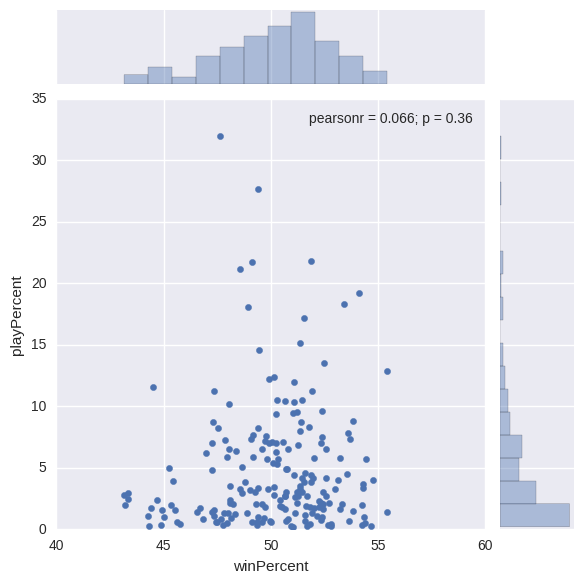

In [6]:
sns.jointplot(x='winPercent', y='playPercent', data=df, size=6, ylim=(0,35), xlim=(40,60), kind="scatter")

if 'mpld3' in sys.modules:
    labels = list("%s: %s<br>Win: %.2f%%<br>Play: %.2f%%<br>" % (x[0], x[1], df['winPercent'][x], df['playPercent'][x]) for x in df.index)
    tooltip = mpld3.plugins.PointHTMLTooltip(points, labels, css=".mpld3-tooltip { background-color: #fff }")
    mpld3.plugins.connect(plt.gcf(), tooltip)

## Win rates as a function of experience

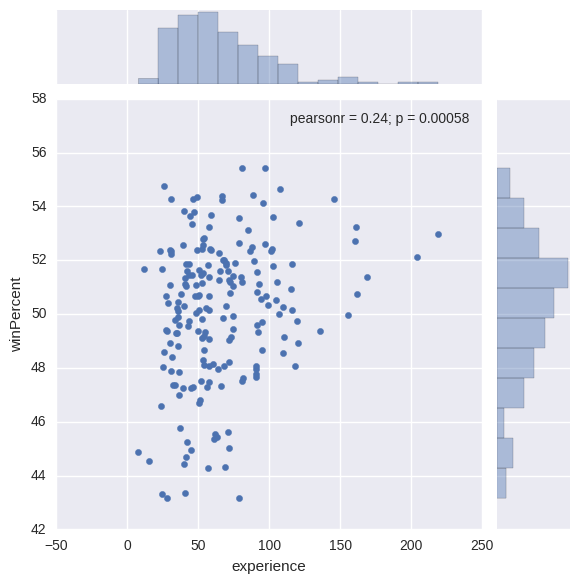

In [7]:
sns.jointplot(x='experience', y='winPercent', data=df, size=6, kind="scatter")

### Histograms of stats

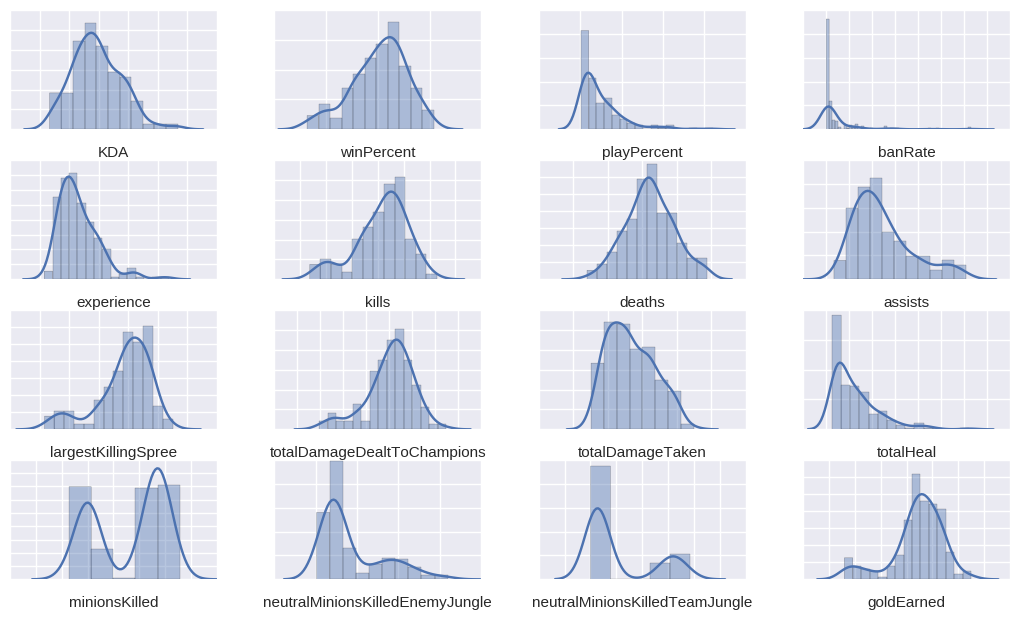

In [8]:
fig, axs = plt.subplots(figsize=(10,6), ncols=4, nrows=4)
for i, c in enumerate(['KDA',] + column_names[:-2]):
    row, col = int(i/4), i%4
    g = sns.distplot(df[c], ax=axs[row, col])
    g.set(yticklabels=[], xticklabels=[])
fig.tight_layout(pad=0)

### Comparison of Experience, Win Percent, KDA, Gold Earned, Total Damage Dealt

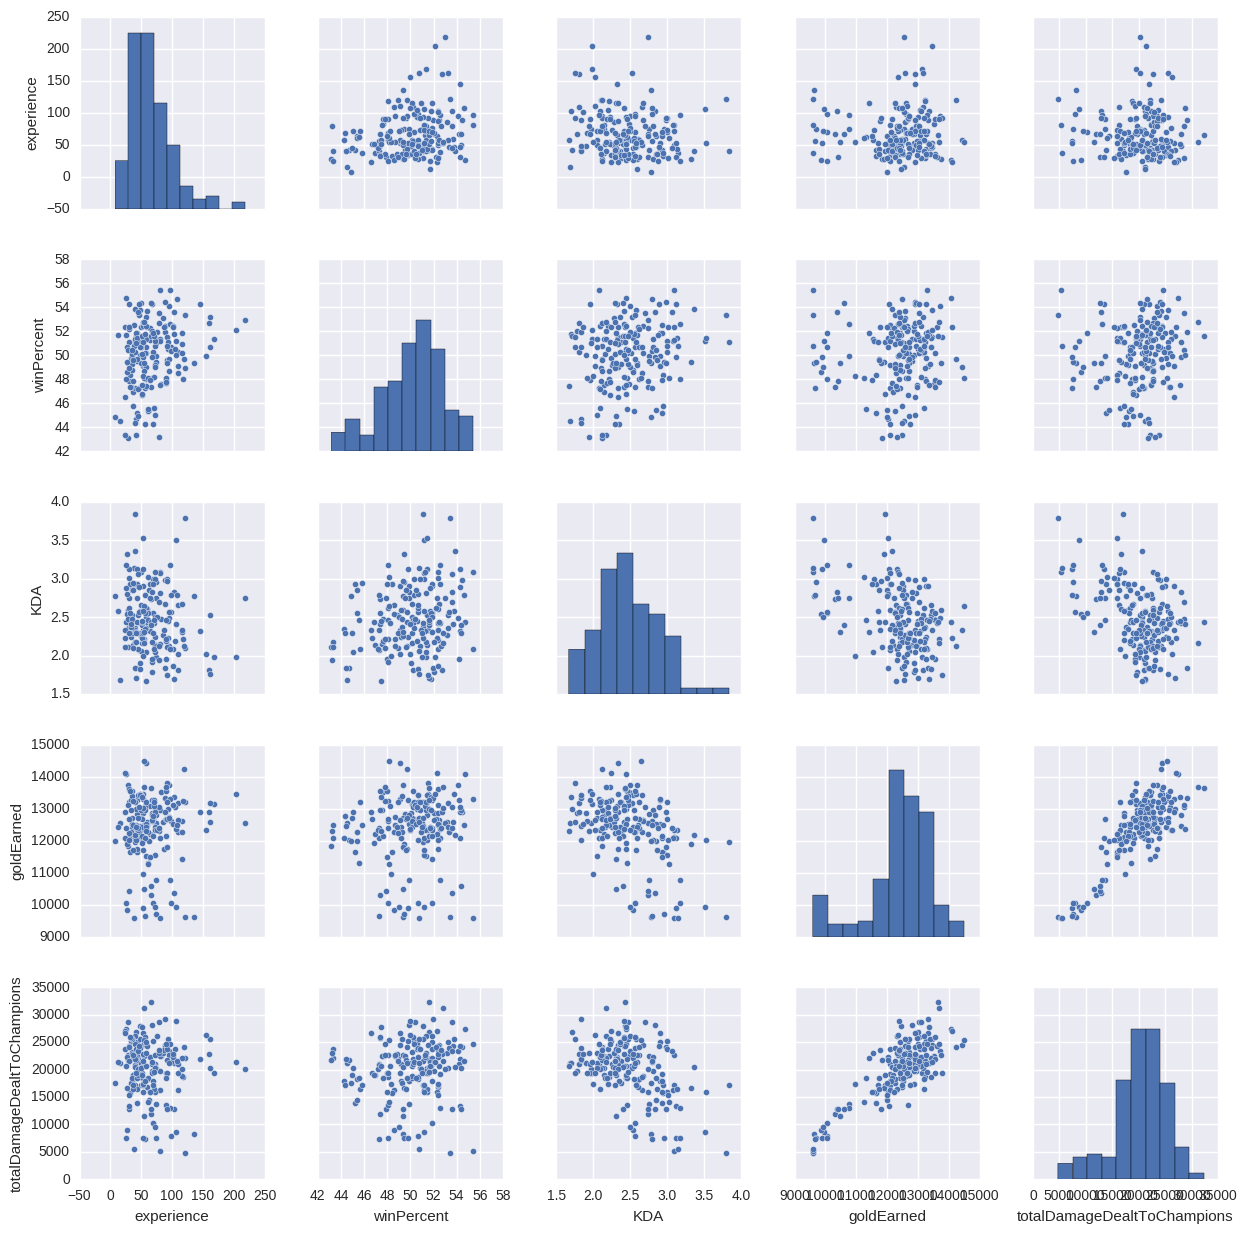

In [9]:
subset = df.filter(('experience', 'winPercent', 'KDA', 'goldEarned', 'totalDamageDealtToChampions'))
sns.pairplot(subset)

### Add a `role` value column back to the DataFrame, from the index.

In [10]:
df['role'] = df.index.get_level_values(level=1)

### Distributions of some variables by role

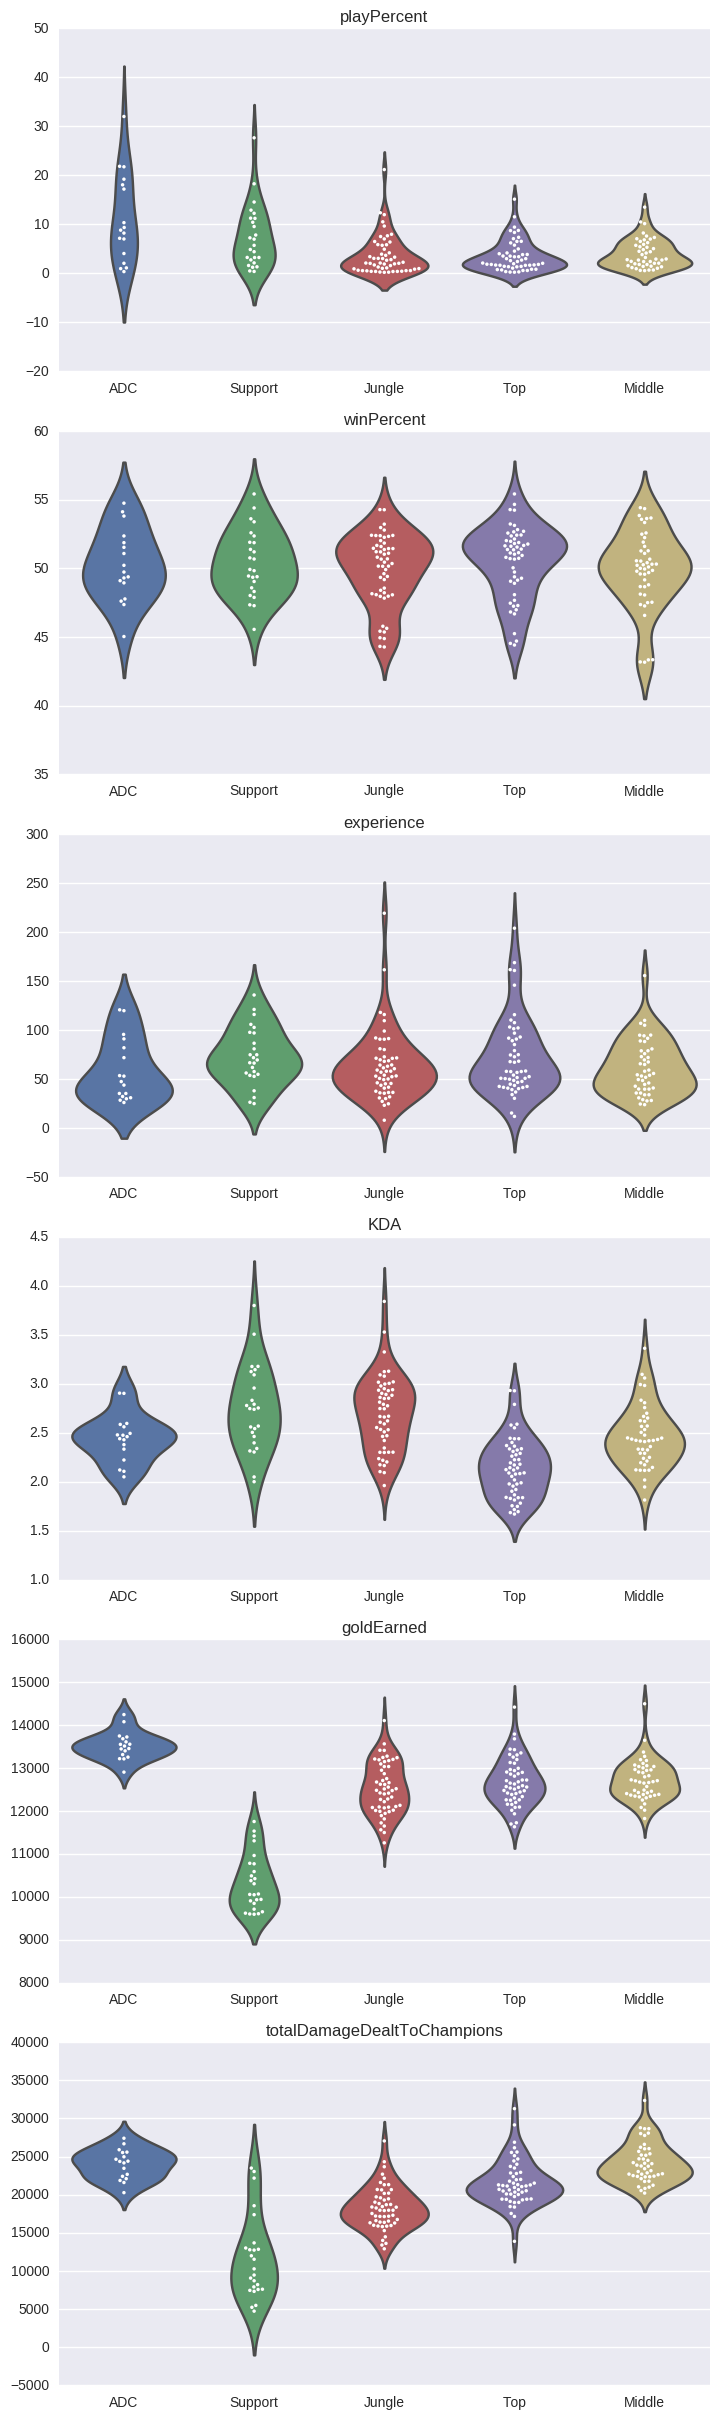

In [11]:
variables = ('playPercent', 'winPercent', 'experience', 'KDA', 'goldEarned', 'totalDamageDealtToChampions')
fig, axs = plt.subplots(figsize=(7, len(variables)*4), ncols=1, nrows=len(variables))
for i, c in enumerate(variables):
    sns.violinplot(y=c, x='role', data=df, inner=None, ax=axs[i]).set(xlabel="", ylabel="", title=c)
    sns.swarmplot(y=c, x='role', data=df, color="w", linewidth=0, size=2.5, ax=axs[i]).set(xlabel="", ylabel="", title=c)
fig.tight_layout(pad=0, h_pad=1)